# Logistic Regression

In this notebook I'll work through some examples using Logistic Regression. I'll start by importing the breast cancer dataset & perform some minimal data exploration. Next we will implement Logistic Regression from scratch. 

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sn 
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve

In [2]:
# load data
data = load_breast_cancer()
X    = data.data
y    = data.target

Note, regarding the labels:
* y=1 => **benign**  
* y=0 => **malignant**

Let's perform a train-test split on the data:

In [3]:
# do train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

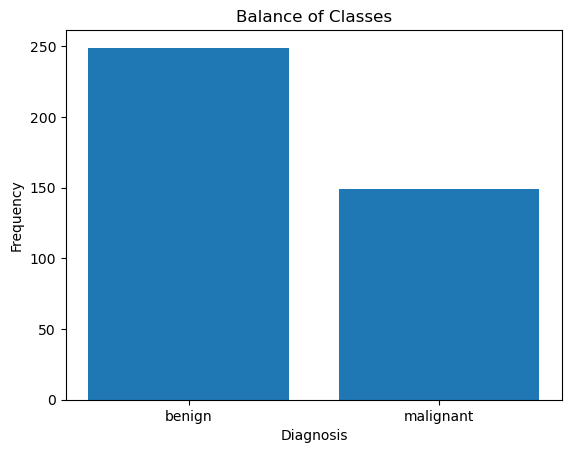

In [4]:
# check if our labels are balanced?
plt.bar(['benign','malignant'],height=[np.sum(y_train),y_train.shape[0]-np.sum(y_train)])
plt.title('Balance of Classes')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.show()

The labels clearly show an imbalance between the two classes. To simplify the discussion here, I will not consider treating this imbalance in this notebook. It should be noted that although the classes are imbalanced, the magnitude of this does not appear to be severe.

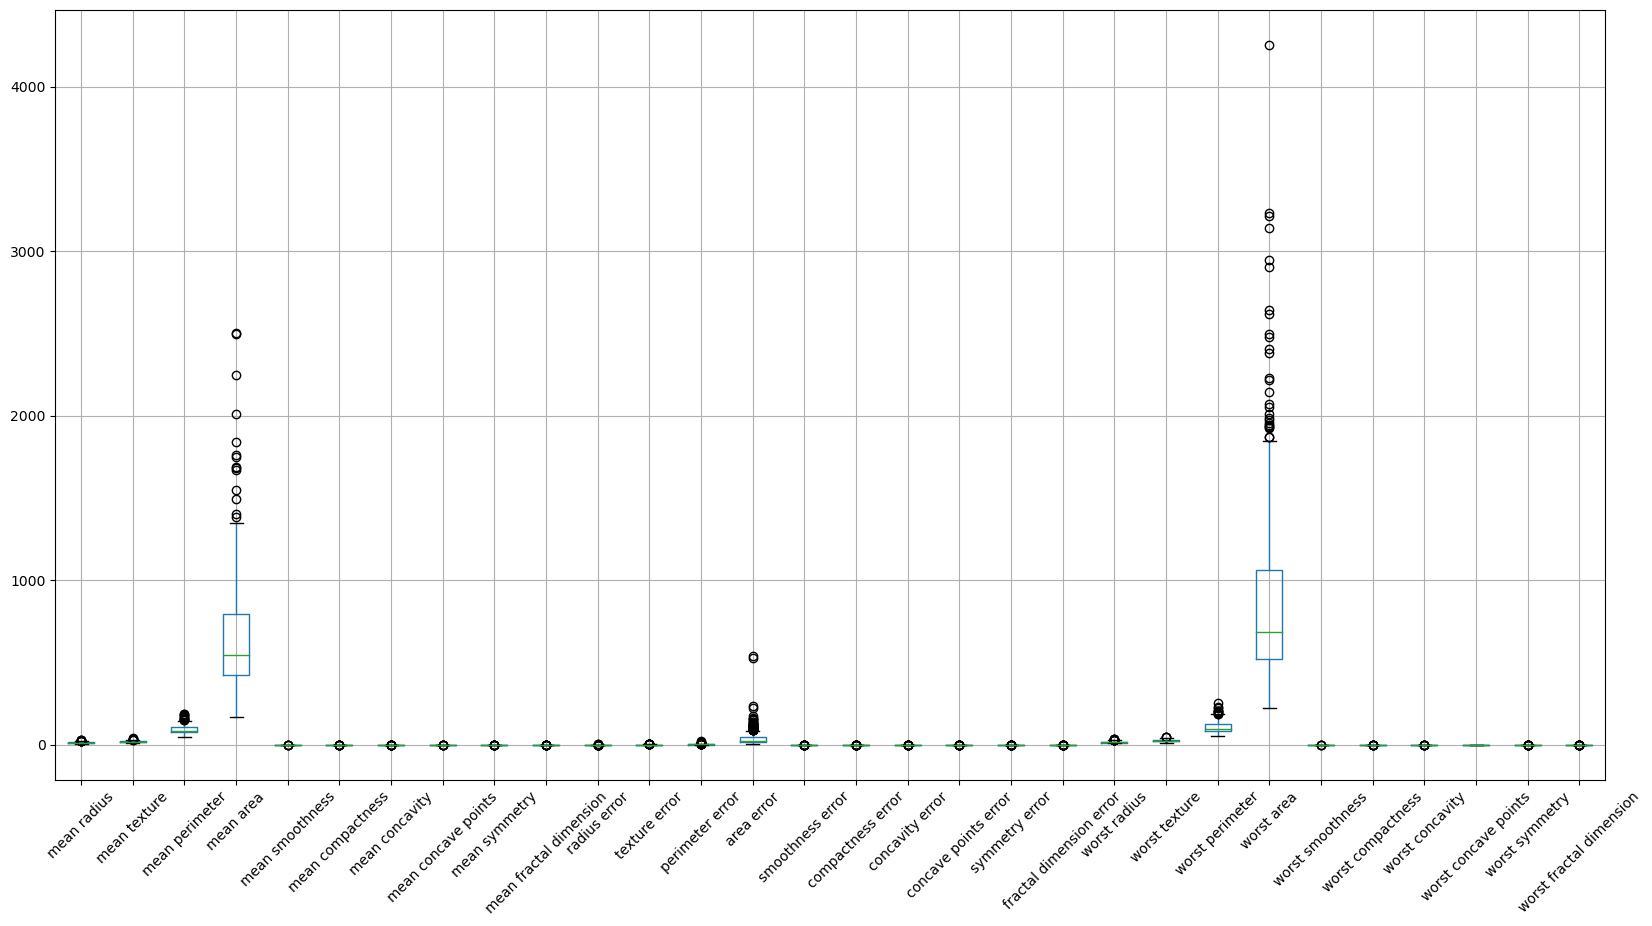

In [5]:
# make a box plot of input features
dfX_train = pd.DataFrame(X_train,columns=data.feature_names)
dfX_test  = pd.DataFrame(X_test,columns=data.feature_names)
dfX_train.boxplot(figsize=(20,10),rot=45)
plt.show()

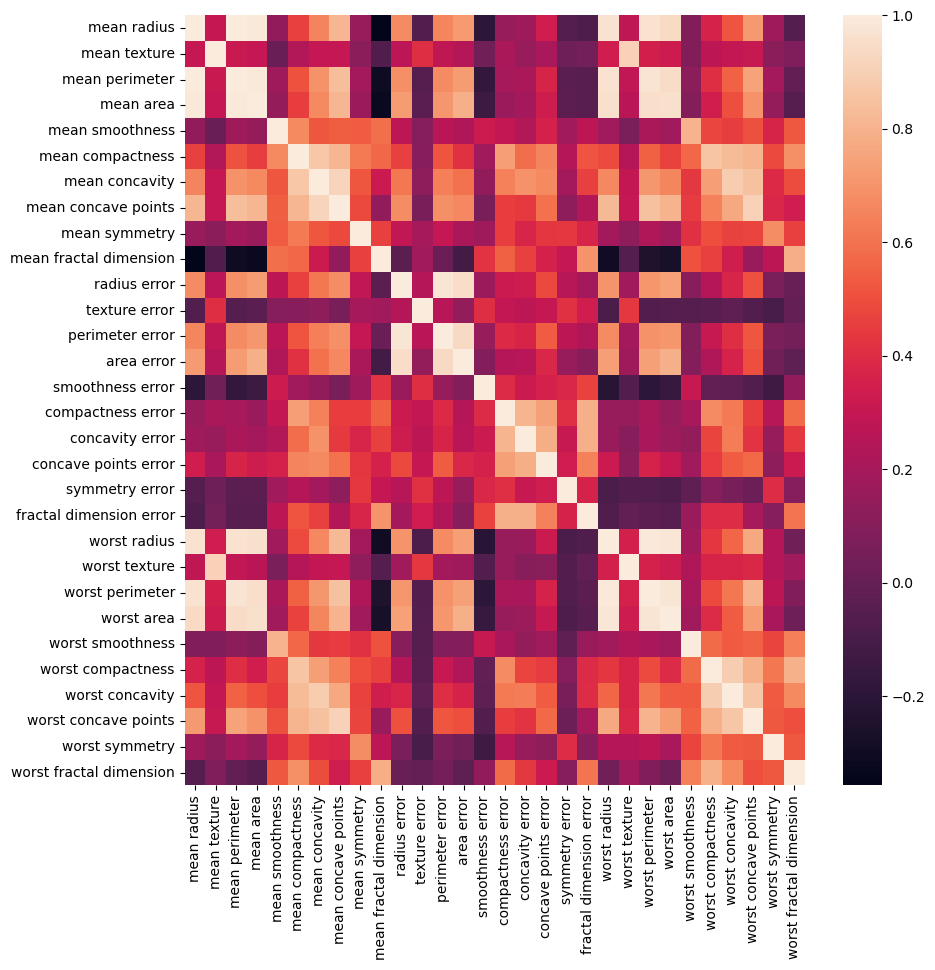

In [6]:
# plot the pearson correlation for our input features
fig, ax = plt.subplots(figsize = (10, 10)) 
dfCorr  = dfX_train.corr() 
sn.heatmap(dfCorr) 
plt.show()

In [7]:
# determine all feature combinations with corelation coef > 0.8
dfCorr     = dfCorr[dfCorr > 0.8].stack().reset_index()
dfCorr     = dfCorr[dfCorr.level_0!=dfCorr.level_1]
sCorrCount = dfCorr.groupby('level_0')['level_1'].agg(lambda x: set(x))
sCorrCount

level_0
area error                                {perimeter error, radius error}
compactness error                                       {concavity error}
concavity error                                       {compactness error}
mean area               {worst radius, mean concave points, mean radiu...
mean compactness        {mean concave points, worst concave points, wo...
mean concave points     {worst radius, mean area, worst perimeter, mea...
mean concavity          {worst concave points, mean concave points, me...
mean perimeter          {worst radius, mean area, mean concave points,...
mean radius             {worst radius, mean area, mean concave points,...
mean smoothness                                        {worst smoothness}
mean texture                                              {worst texture}
perimeter error                                {area error, radius error}
radius error                                {perimeter error, area error}
worst area              {worst

In [8]:
# determine complete list of correlated features
corr_features = set()
for features in sCorrCount:
    corr_features = corr_features | features

In [9]:
# determine list of correlated features to remove
to_remove = set()
for keep, remove in sCorrCount.items():
    # check if we should add to our remove list?
    if corr_features and (keep not in to_remove):
        # add to list of features to remove 
        to_remove = to_remove | remove
        # update corr_features
        corr_features = corr_features - remove
to_remove

{'concavity error',
 'mean concave points',
 'mean concavity',
 'mean perimeter',
 'mean radius',
 'perimeter error',
 'radius error',
 'worst area',
 'worst compactness',
 'worst concave points',
 'worst concavity',
 'worst perimeter',
 'worst radius',
 'worst smoothness',
 'worst texture'}

We now see which features are most frequently correlated with other features in the dataset. Let's select out, and remove, all features that are highly correlated with more than 2 other features: 

In [10]:
# drop correlated features
dfX_train.drop(list(to_remove), axis=1, inplace=True)
dfX_test.drop(list(to_remove), axis=1, inplace=True)

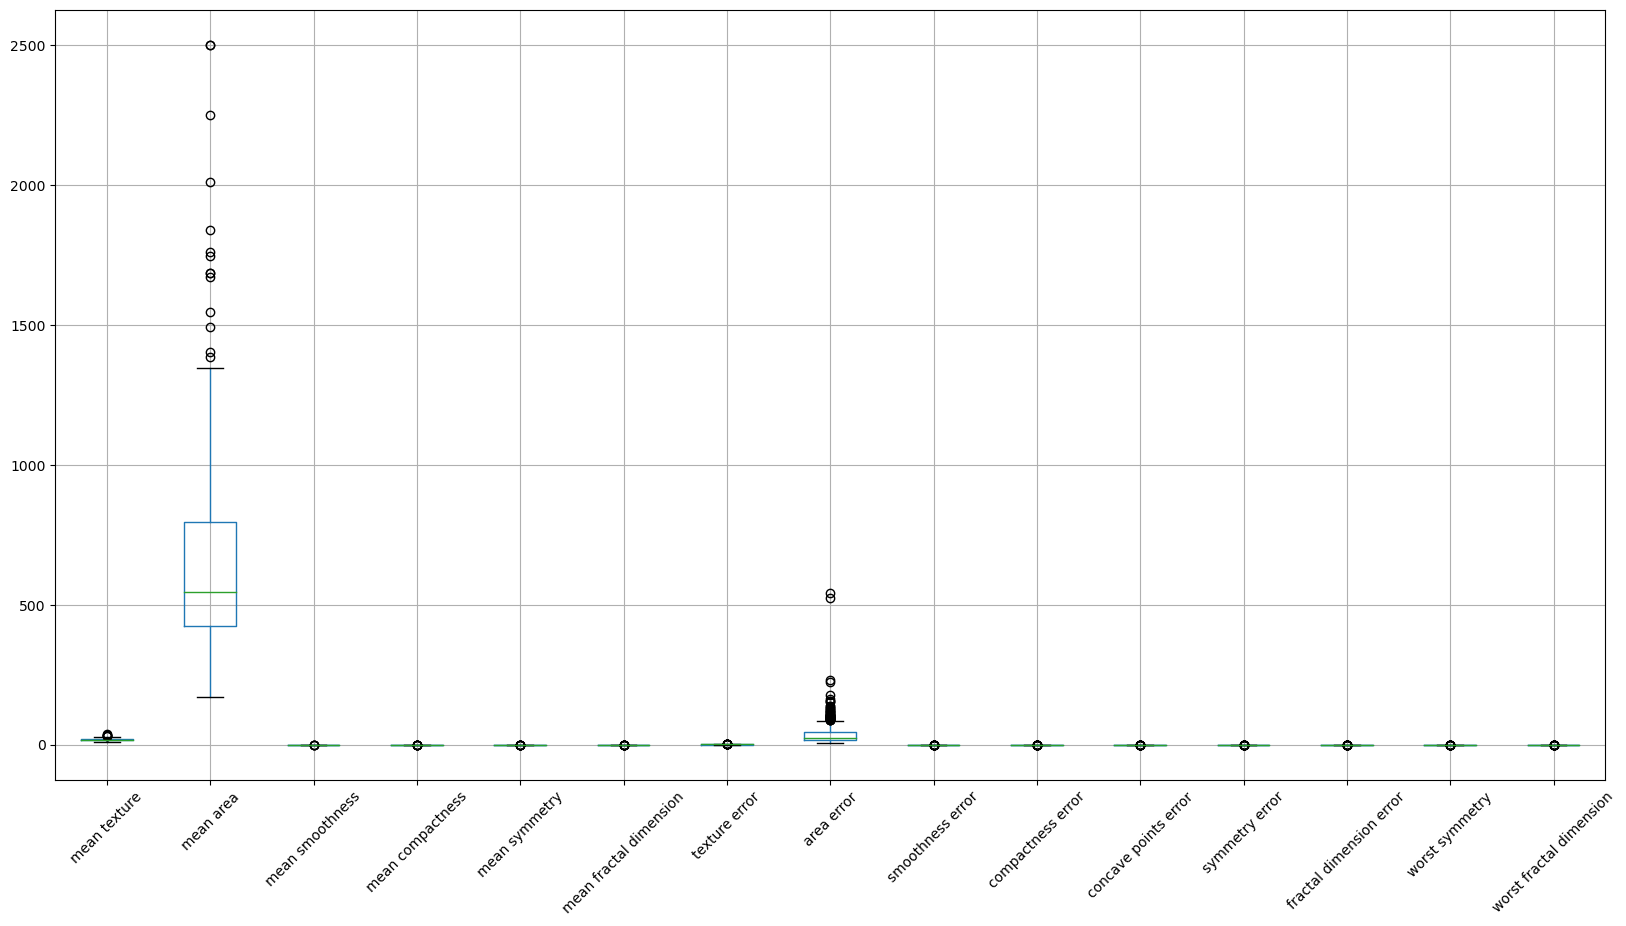

In [11]:
# box plot of truncated feature set
dfX_train.boxplot(figsize=(20,10),rot=45)
plt.show()

In [12]:
class LogR(object):
    """
    Class to encompass the logistic regression model with the Newton-Raphson algorithm
    """
    
    def __init__(self, max_iter: int=100, tol: float=1e-4) -> None:
        """
        Initialiser function for a class instance
        
        Inputs:
            max_iter      -> maximum number of iterations of the Newton-Raphson algorithm
            tol           -> tolerance threshold to terminate the Newton-Raphson algorithm
        """
        self.__B        = np.array([])
        self.__max_iter = max_iter
        self.__tol      = tol
    
    def train(self, Xin: np.array, Yin: np.array) -> None:
        """
        Training function for a class instance
        
        Inputs:
            Xin -> training set of predictor features
            Yin -> training set of associated labels
        """
        # add column of 1's to independent variables
        X       = np.ones((Xin.shape[0],Xin.shape[1]+1))
        X[:,1:] = Xin            
        # ensure correct dimensions for the input labels
        Y = Yin.reshape(-1,1)
        # prepare parameters array
        self.__B = np.zeros((X.shape[1],1))
        # loop through the Newton-Raphson algorithm
        for _ in range(self.__max_iter):
            # compute conditional probabilities
            P = 1/(1 + np.exp(-np.matmul(X,self.__B)))
            # built diagonal matrix
            D = np.diag(np.multiply(P,(1-P)).flatten())
            # parameter update rule
            Minv      = np.linalg.inv(np.matmul(np.matmul(X.T,D),X))
            dB        = np.matmul(np.matmul(Minv,X.T),np.subtract(Y,P))
            self.__B += dB
            # check if we've reached the tolerance 
            if self.__tol > np.linalg.norm(dB):
                break
        
    def predict(self, Xin: np.array, return_prob: bool=False) -> np.array:
        """
        Predict function for a class instance
        
        Inputs:
            Xin         -> input predictor features
            return_prob -> boolean to determine if probability or label is returned
        Outputs:
            numpy array of model predictions for the Xin inputs
        """
        # add column of 1's to independent variables
        X       = np.ones((Xin.shape[0],Xin.shape[1]+1))
        X[:,1:] = Xin
        # calculate predictions
        Yp      = 1/(1 + np.exp(-np.matmul(X,self.__B)))
        # return predictions
        if not return_prob:
            Yp = Yp.round(decimals=0)
        return(Yp)
    
    def return_B(self) -> np.array:
        """
        Function to return model parameters
        
        Output:
            self.__B -> array of learned model parameters
        """
        return(self.__B)    

Since the input features are not on the same scale, we'll scale them to mean 0 and standard deviation 1 before modelling

In [13]:
# scale input features
scaler  = StandardScaler()
X_train = scaler.fit_transform(dfX_train)
X_test  = scaler.transform(dfX_test)

In [14]:
# fit our logistic regression model & generate predictions
lr    = LogR()
lr.train(X_train,y_train)
ypred = lr.predict(X_test) 
yprob = lr.predict(X_test,return_prob=True)

In [15]:
# evaluate model performance
print("accuracy: %.2f" % accuracy_score(y_test,ypred))
print("precision: %.2f" % precision_score(y_test,ypred))
print("recall: %.2f" % recall_score(y_test,ypred))

accuracy: 0.96
precision: 0.98
recall: 0.96


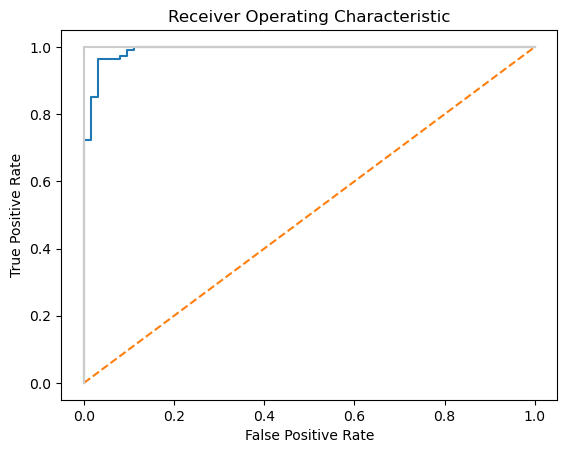

In [16]:
# create a ROC plot
fpr,tpr,_ = roc_curve(y_test, yprob)
plt.plot(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".8"), plt.plot([1, 1] , c=".8")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Instead of making a logistic regression algorithm from scratch, we can use the API provided by scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [17]:
# imports
from sklearn.linear_model import LogisticRegression

In [18]:
# fit our data and generate predictions
lr    = LogisticRegression(penalty=None)
lr.fit(X_train,y_train)
ypred = lr.predict(X_test)
yprob = lr.predict_proba(X_test)

In [19]:
# evaluate model performance
print("accuracy: %.2f" % accuracy_score(y_test,ypred))
print("precision: %.2f" % precision_score(y_test,ypred))
print("recall: %.2f" % recall_score(y_test,ypred))

accuracy: 0.96
precision: 0.98
recall: 0.96


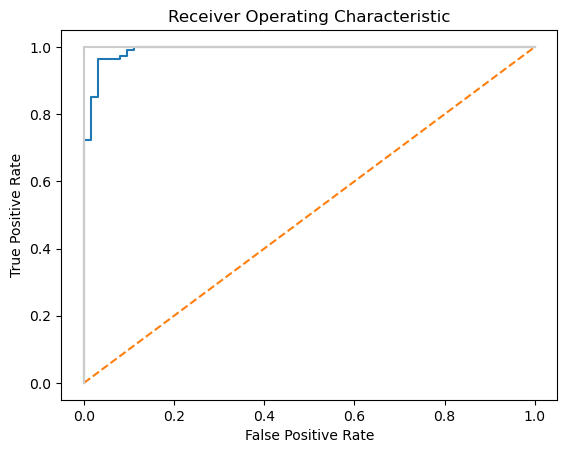

In [20]:
# create a ROC plot
fpr,tpr,_ = roc_curve(y_test, yprob[:,1])
plt.plot(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".8"), plt.plot([1, 1] , c=".8")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()